<div style="
    background-color:rgb(210, 230, 255);
    color:rgb(0, 0, 0);
    padding: 10px;
    border-radius: 10px;
    font-weight: bold;">
<h3>Modèle d'apprentissage automatique pour la prédiction d’usage le plus probable d'une friche en France</h3>
<ul>
    <li>Dans le cadre du projet PROFIL : https://github.com/heuzef/cartofriches</li>
    <li>Auteur : Heuzef (https://heuzef.com)</li>
    <li>Juin 2025</li>
    <li>Destiné au CEREMA</li>
    <li>Les données exploitées sont issues data.gouv.fr, respectant le Standard Friches (version 2022 - rev. v2023-12)</li>
</div>

# Import des librairies

In [1]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jinja2
import re

# Chargement des données

In [3]:
# Chargement des données de data.gouv.fr, la 35ème colonne possède des Dtype mixte, l'option low_memory=False permet de contourner le problème.
# https://www.data.gouv.fr/fr/datasets/sites-references-dans-cartofriches/#/resources
# https://github.com/cnigfr/schema-friches

df_friches = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/74feb3ed-5f9f-4ef8-8fab-b0128d569a99", sep=";", low_memory=False)

print("Données des sites référencés dans Cartofriches disponible sur data.gouv.fr (respectant le standard CNIG) :")
print(f"{df_friches.shape[0]} friches chargées — {df_friches.shape[1]} variables")
print("Pas de doublon detectés")

Données des sites référencés dans Cartofriches disponible sur data.gouv.fr (respectant le standard CNIG) :
28115 friches chargées — 50 variables
Pas de doublon detectés


In [4]:
def audit(df):
    """
    Audite un DataFrame.
    
    Paramètres:
    df (pandas.DataFrame): Le DataFrame à analyser
    
    Retourne:
    pandas.DataFrame: Un DataFrame contenant pour chaque colonne:
                     - le nombre de valeurs manquantes
                     - le pourcentage de valeurs manquantes
                     - le type de données
                     - le nombre de valeurs uniques
    """
    # Calculer le nombre de valeurs manquantes par colonne
    missing_values = df.isnull().sum()
    
    # Calculer le pourcentage de valeurs manquantes
    missing_percentage = (missing_values / len(df)) * 100
    
    # Obtenir les types de données de chaque colonne
    dtypes = df.dtypes

    # Obtenir le nombre de valeurs uniques de chaque colonne
    nunique = df.nunique()
    
    # Créer un DataFrame avec les résultats
    audit = pd.DataFrame({
        'Manquantes': missing_values,
        '(%)': missing_percentage.round(2),
        'Type': dtypes,
        'Uniques': nunique
    })
    
    # Trier par pourcentage de valeurs manquantes (décroissant)
    audit = audit.sort_values('(%)', ascending=True)
    
    return audit

audit(df_friches)

,Manquantes,(%),Type,Uniques
site_id,0,0.00,object,28115
site_nom,0,0.00,object,24071
site_type,0,0.00,object,19
site_identif_date,0,0.00,object,581
site_actu_date,0,0.00,object,532
site_occupation,0,0.00,object,20
site_statut,0,0.00,object,4
bati_type,0,0.00,object,9
bati_patrimoine,0,0.00,object,5
bati_pollution,0,0.00,object,4


# Isolation des données des friches reconverties

In [5]:
print(f"Le nombre de valeurs manquantes dans la colonne 'site_reconv_type' est : {df_friches['site_reconv_type'].isna().sum()}")
print(f"Nombre de friches reconverties : {df_friches['site_reconv_type'].count()}")

Le nombre de valeurs manquantes dans la colonne 'site_reconv_type' est : 25503
Nombre de friches reconverties : 2612


In [6]:
df_friches_reconv = df_friches.dropna(subset=['site_reconv_type'])
print(f"{df_friches_reconv.shape[0]} friches chargées — {df_friches_reconv.shape[1]} variables")

2612 friches chargées — 50 variables


In [7]:
# Supprimer les friches dont la reconversion est 'autre' ou 'inconnu'
for val in ['autre', 'inconnu']:
    df_friches_reconv = df_friches_reconv.drop(df_friches_reconv[df_friches_reconv['site_reconv_type'] == val].index)

# Affichez les résultats
print(f"{df_friches_reconv.shape[0]} friches chargées — {df_friches_reconv.shape[1]} variables")
print("Variable cible :")
display(df_friches_reconv['site_reconv_type'].value_counts())

2331 friches chargées — 50 variables
Variable cible :


site_reconv_type
habitat                         1100
mixte                            351
autres activités économiques     328
équipement public                215
commerce                          95
renaturation                      69
bureau                            65
aménagement d'espace public       47
industrie                         33
panneaux photovoltaiques          27
�nergie, hors photovoltaique       1
Name: count, dtype: int64

# Nettoyage

1. "site_ademe_url" => 2331 NaNs (100.0%)
2. "site_projet_url" => 2331 NaNs (100.0%)
3. "site_reconv_annee" => 2331 NaNs (100.0%)
4. "bati_surface" => 2331 NaNs (100.0%)
5. "sol_pollution_annee" => 2331 NaNs (100.0%)
6. "sol_pollution_commentaire" => 2331 NaNs (100.0%)
7. "sol_depollution_fiche" => 2331 NaNs (100.0%)
8. "desserte_distance" => 2331 NaNs (100.0%)
9. "desserte_commentaire" => 2331 NaNs (100.0%)
10. "geomsurf" => 2331 NaNs (100.0%)
11. "activite_code" => 2311 NaNs (99.0%)
12. "activite_libelle" => 2260 NaNs (97.0%)
13. "urba_zone_formdomi" => 2012 NaNs (86.0%)
14. "site_url" => 1939 NaNs (83.0%)
15. "source_contact" => 1892 NaNs (81.0%)
16. "site_adresse" => 1849 NaNs (79.0%)
17. "activite_fin_annee" => 1385 NaNs (59.0%)
18. "site_securite" => 1172 NaNs (50.0%)
19. "source_url" => 983 NaNs (42.0%)
20. "local_ancien_annee" => 902 NaNs (39.0%)
21. "local_recent_annee" => 622 NaNs (27.0%)
22. "urba_zone_type" => 254 NaNs (11.0%)
23. "urba_zone_lib" => 254 NaNs (11.0%)
24. "ur

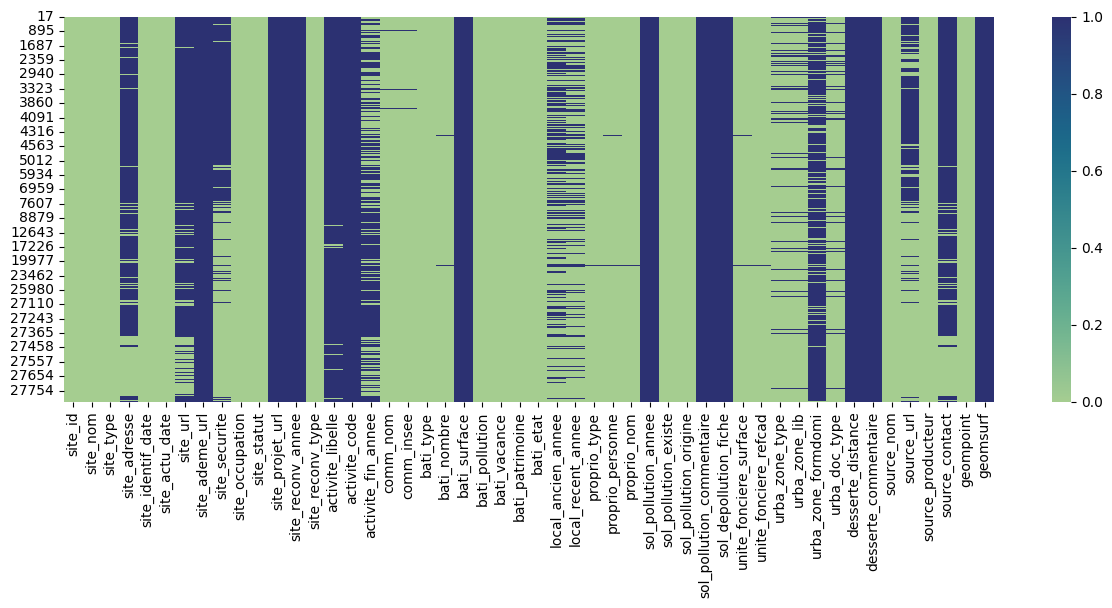

In [8]:
# Fonction de vérification :
def check_nan(df):
    results = []

    for col in df.columns:
        nan_count = df[col].isna().sum()
        nan_percentage = np.round(nan_count * 100 / df.shape[0])
        results.append((col, nan_count, nan_percentage))

    results.sort(key=lambda x: x[2], reverse=True) # Trier les résultats par pourcentage de NaNs

    total_nans = sum(df.isna().sum())

    for line_number, (col, nan_count, nan_percentage) in enumerate(results, start=1):
        print(f'{line_number}. "{col}" => {nan_count} NaNs ({nan_percentage}%)')

    print(f"\nTotal NaNs : {total_nans}")

    # Visualiser dans un graphique les NaNs
    plt.figure(figsize=(15,5))
    sns.heatmap(df_friches_reconv.isna(), cmap="crest")

check_nan(df_friches_reconv)

1. "site_ademe_url" => 2331 NaNs (100.0%)
2. "site_projet_url" => 2331 NaNs (100.0%)
3. "site_reconv_annee" => 2331 NaNs (100.0%)
4. "bati_surface" => 2331 NaNs (100.0%)
5. "sol_pollution_annee" => 2331 NaNs (100.0%)
6. "sol_pollution_origine" => 2330 NaNs (100.0%)
7. "sol_pollution_commentaire" => 2331 NaNs (100.0%)
8. "sol_depollution_fiche" => 2331 NaNs (100.0%)
9. "desserte_distance" => 2331 NaNs (100.0%)
10. "desserte_commentaire" => 2331 NaNs (100.0%)
11. "geomsurf" => 2331 NaNs (100.0%)
12. "activite_code" => 2311 NaNs (99.0%)
13. "activite_libelle" => 2260 NaNs (97.0%)
14. "urba_zone_formdomi" => 2012 NaNs (86.0%)
15. "site_url" => 1939 NaNs (83.0%)
16. "bati_vacance" => 1901 NaNs (82.0%)
17. "site_securite" => 1892 NaNs (81.0%)
18. "site_occupation" => 1892 NaNs (81.0%)
19. "bati_type" => 1898 NaNs (81.0%)
20. "bati_patrimoine" => 1894 NaNs (81.0%)
21. "source_contact" => 1892 NaNs (81.0%)
22. "bati_pollution" => 1856 NaNs (80.0%)
23. "site_adresse" => 1849 NaNs (79.0%)
24. "s

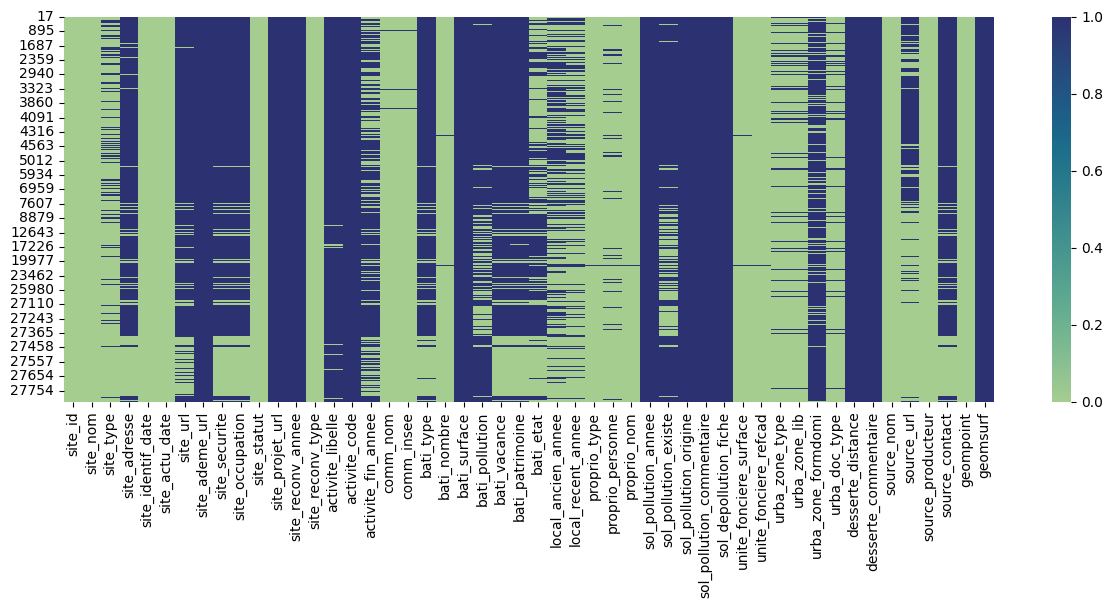

In [9]:
# Remplacer les modalités spécifiques par des NaN dans le DataFrame, pour révéler les valeurs manquantes cachées
df_friches_reconv = df_friches_reconv.replace(["nan", "NaN", "NA", "Na", "N/A", "none", "null", "", "inconnu", "autre", "vide", "None", "NONE", "NA", "na", "Inconnu", "INCONNU", "Autre", "AUTRE"], pd.NA)

check_nan(df_friches_reconv)

1. "urba_zone_formdomi" => 2012 NaNs (86.0%)
2. "site_url" => 1939 NaNs (83.0%)
3. "bati_vacance" => 1901 NaNs (82.0%)
4. "site_securite" => 1892 NaNs (81.0%)
5. "site_occupation" => 1892 NaNs (81.0%)
6. "bati_type" => 1898 NaNs (81.0%)
7. "bati_patrimoine" => 1894 NaNs (81.0%)
8. "source_contact" => 1892 NaNs (81.0%)
9. "bati_pollution" => 1856 NaNs (80.0%)
10. "site_adresse" => 1849 NaNs (79.0%)
11. "sol_pollution_existe" => 1685 NaNs (72.0%)
12. "activite_fin_annee" => 1497 NaNs (64.0%)
13. "bati_etat" => 1102 NaNs (47.0%)
14. "source_url" => 983 NaNs (42.0%)
15. "local_ancien_annee" => 902 NaNs (39.0%)
16. "local_recent_annee" => 622 NaNs (27.0%)
17. "site_type" => 334 NaNs (14.0%)
18. "urba_zone_type" => 254 NaNs (11.0%)
19. "urba_zone_lib" => 254 NaNs (11.0%)
20. "urba_doc_type" => 244 NaNs (10.0%)
21. "proprio_personne" => 169 NaNs (7.0%)
22. "comm_nom" => 23 NaNs (1.0%)
23. "comm_insee" => 23 NaNs (1.0%)
24. "bati_nombre" => 24 NaNs (1.0%)
25. "proprio_type" => 17 NaNs (1.0%)
2

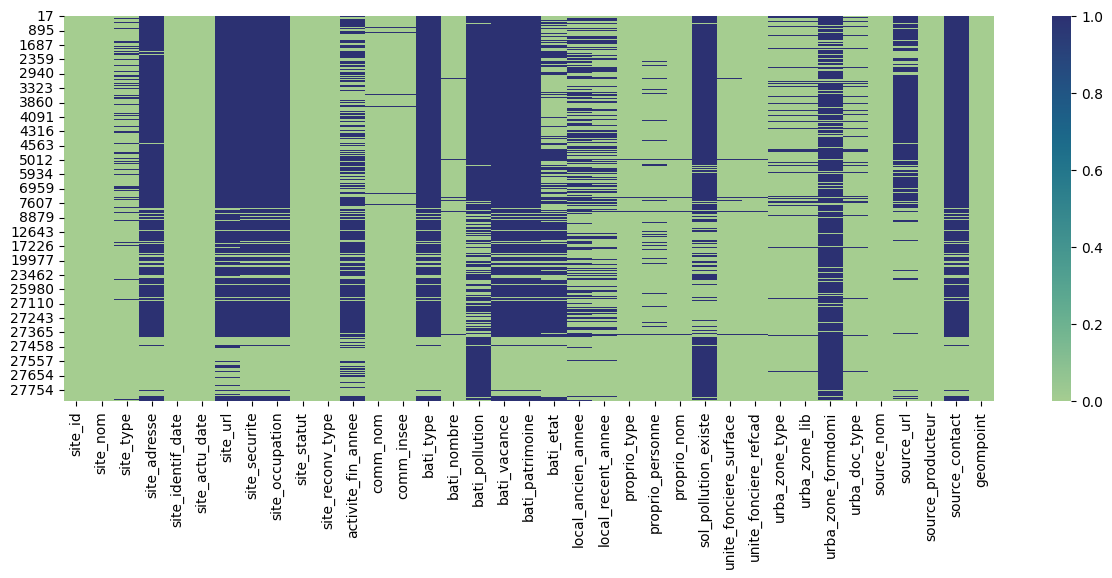

In [10]:
# Suppression des variables innexploitable (taux de valeur manquante suppérieur à 90%)
empty_values = ["site_ademe_url", "site_projet_url", "site_reconv_annee", "activite_libelle", "activite_code", "bati_surface", "sol_pollution_annee", "sol_pollution_origine", "sol_pollution_commentaire", "sol_depollution_fiche", "desserte_distance", "desserte_commentaire", "geomsurf"]

df_friches_reconv = df_friches_reconv.drop(columns=empty_values)

check_nan(df_friches_reconv)

# Analse des variables restantes

1. "urba_zone_formdomi" => 2012 NaNs (86.0%) => À conserver
2. "site_url" => 1939 NaNs (83.0%) => Peut être supprimés car sans interêt
3. "bati_vacance" => 1901 NaNs (82.0%) => À conserver
4. "site_securite" => 1892 NaNs (81.0%) => À conserver
5. "site_occupation" => 1892 NaNs (81.0%) => À conserver
6. "bati_type" => 1898 NaNs (81.0%) => À conserver
7. "bati_patrimoine" => 1894 NaNs (81.0%) => À conserver
8. "source_contact" => 1892 NaNs (81.0%) => Peut être supprimés car sans interêt
9. "site_adresse" => 1849 NaNs (79.0%) => Ne peut pas être exploité ainsi, de plus nous disposons déjà de la variable "geompoint" qui présente des coordonées GPS sans valeur manquante
10. "bati_pollution" => 1808 NaNs (78.0%) => À conserver
11. "sol_pollution_existe" => 1685 NaNs (72.0%) => À conserver
12. "activite_fin_annee" => 1497 NaNs (64.0%) => À conserver
13. "bati_etat" => 1102 NaNs (47.0%) => À conserver
14. "source_url" => 983 NaNs (42.0%) => Peut être supprimés car sans interêt
15. "local_ancien_annee" => 902 NaNs (39.0%) => À conserver
16. "local_recent_annee" => 622 NaNs (27.0%) => À conserver
17. "urba_zone_type" => 254 NaNs (11.0%) => À conserver
18. "urba_zone_lib" => 254 NaNs (11.0%) => Peut être supprimés car redondant avec urba_zone_type
19. "urba_doc_type" => 241 NaNs (10.0%) => À conserver
20. "site_type" => 43 NaNs (2.0%) => À conserver
21. "comm_nom" => 23 NaNs (1.0%) => Peut être supprimés car redondant avec comm_insee
22. "comm_insee" => 23 NaNs (1.0%) => CF "geompoint"
23. "bati_nombre" => 24 NaNs (1.0%) => À conserver
24. "proprio_type" => 17 NaNs (1.0%) => La classification des types de propriétaires dans les fichiers fonciers, telle que "catpro3", demande à faire des expérimentations
25. "proprio_personne" => 24 NaNs (1.0%) => À conserver
26. "proprio_nom" => 17 NaNs (1.0%) => Demande à faire des expérimentations
27. "unite_fonciere_surface" => 24 NaNs (1.0%) => À conserver
28. "unite_fonciere_refcad" => 15 NaNs (1.0%) => Demande à faire des expérimentations (les identifiants de parcelles sont formatés sur 14 caractères suivant le format idpar des fichiers fonciers)
29. "site_id" => 0 NaNs (0.0%) => Index à supprimer
30. "site_nom" => 0 NaNs (0.0%) => Peut être supprimés car sans interêt
31. "site_identif_date" => 0 NaNs (0.0%) => À conserver
32. "site_actu_date" => 0 NaNs (0.0%) => À conserver
33. "site_statut" => 0 NaNs (0.0%) => Incohérence ici, toutes les friches ici n'affichent pas le status "friche reconvertie", à supprimer
34. "site_reconv_type" => 0 NaNs (0.0%) => Variable cible
35. "source_nom" => 0 NaNs (0.0%) => Peut être supprimés car sans interêt
36. "source_producteur" => 0 NaNs (0.0%) => Peut être supprimés car sans interêt
37. "geompoint" => 0 NaNs (0.0%) => À conserver, l'exploitation de "geompoint" serait peut-être plus pertinant, demande à faire des expérimentations

2331 friches chargées — 22 variables
1. "urba_zone_formdomi" => 2012 NaNs (86.0%)
2. "bati_vacance" => 1901 NaNs (82.0%)
3. "site_securite" => 1892 NaNs (81.0%)
4. "site_occupation" => 1892 NaNs (81.0%)
5. "bati_type" => 1898 NaNs (81.0%)
6. "bati_patrimoine" => 1894 NaNs (81.0%)
7. "bati_pollution" => 1856 NaNs (80.0%)
8. "sol_pollution_existe" => 1685 NaNs (72.0%)
9. "activite_fin_annee" => 1497 NaNs (64.0%)
10. "bati_etat" => 1102 NaNs (47.0%)
11. "local_ancien_annee" => 902 NaNs (39.0%)
12. "local_recent_annee" => 622 NaNs (27.0%)
13. "site_type" => 334 NaNs (14.0%)
14. "urba_zone_type" => 254 NaNs (11.0%)
15. "urba_doc_type" => 244 NaNs (10.0%)
16. "proprio_personne" => 169 NaNs (7.0%)
17. "bati_nombre" => 24 NaNs (1.0%)
18. "unite_fonciere_surface" => 24 NaNs (1.0%)
19. "site_identif_date" => 0 NaNs (0.0%)
20. "site_actu_date" => 0 NaNs (0.0%)
21. "site_reconv_type" => 0 NaNs (0.0%)
22. "geompoint" => 0 NaNs (0.0%)

Total NaNs : 20202


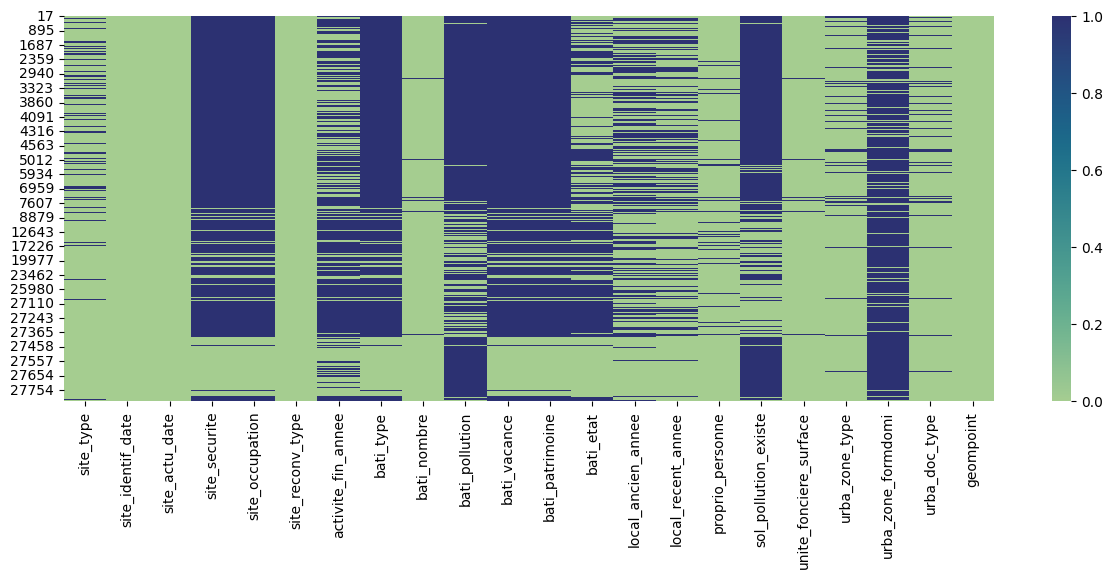

In [11]:
# Suppression des variables inutiles
del_values = ["site_url", "source_contact", "site_adresse", "source_url", "urba_zone_lib", "comm_nom", "proprio_type", "proprio_nom", "unite_fonciere_refcad", "site_id", "site_nom", "site_statut", "source_nom", "source_producteur", "comm_insee"]
df_friches_reconv = df_friches_reconv.drop(columns=del_values)

print(f"{df_friches_reconv.shape[0]} friches chargées — {df_friches_reconv.shape[1]} variables")
check_nan(df_friches_reconv)

# Pré-traitement des variables

## Analyse des types

In [12]:
def dtypes_analyzer(data, qty=3):
    """
    Autor :  Heuzef (heuzef.com)
    Version : 1.0
    Description : Allows you to analyze a synthetic sample of the dataset

    Parameters
    ----------
    data : specify dataset name to analize.
    qty : quantity of the sample to display.
    """
    sample = []
    for i in data.columns:
        list_values = str(list(data[i].sample(qty)))
        sample.append(list_values)

        tab = {
            'Col': list(data.columns),
            'Dtype': list(data.dtypes),
            'Sample': sample
        }

    analize = pd.DataFrame(data=tab)
    pd.options.display.max_rows = data.shape[1]

    return(analize.style.set_properties(color="#1E90FF", align="right", **{'background-color': '#F0F8FF'}))

dtypes_analyzer(df_friches_reconv, 3)

,Col,Dtype,Sample
0,site_type,object,"[""friche d'habitat"", ""friche d'habitat"", 'mixte']"
1,site_identif_date,object,"['2000-12-31', '2025-01-15', '2020-07-01']"
2,site_actu_date,object,"['2024-02-13', '2024-02-13', '2022-08-02']"
3,site_securite,object,"[nan, nan, ]"
4,site_occupation,object,"[, , ]"
5,site_reconv_type,object,"['habitat', 'mixte', 'habitat']"
6,activite_fin_annee,object,"[nan, '2012', '2020']"
7,bati_type,object,"[, , ]"
8,bati_nombre,float64,"[1.0, 3.0, 2.0]"
9,bati_pollution,object,"[, , ]"


In [13]:
# Reset de la fonction
pd.reset_option("display.max_rows")

**Conclusion des conversions de type à appliquer**

* site_identif_date => À convertir en Datetime
* site_actu_date => À convertir en Datetime
* activite_fin_annee => À convertir en Datetime
* bati_nombre => À convertir en INT
* local_ancien_annee => À convertir en Datetime
* local_recent_annee => À convertir en Datetime
* unite_fonciere_surface => À convertir en INT
* geompoint => Créer deux variables float latitude + longitude
* Toutes les autres variables object doivent être encodées et converties en numérique

## Suppression des champs date

2331 friches chargées — 17 variables
1. "urba_zone_formdomi" => 2012 NaNs (86.0%)
2. "bati_vacance" => 1901 NaNs (82.0%)
3. "site_securite" => 1892 NaNs (81.0%)
4. "site_occupation" => 1892 NaNs (81.0%)
5. "bati_type" => 1898 NaNs (81.0%)
6. "bati_patrimoine" => 1894 NaNs (81.0%)
7. "bati_pollution" => 1856 NaNs (80.0%)
8. "sol_pollution_existe" => 1685 NaNs (72.0%)
9. "bati_etat" => 1102 NaNs (47.0%)
10. "site_type" => 334 NaNs (14.0%)
11. "urba_zone_type" => 254 NaNs (11.0%)
12. "urba_doc_type" => 244 NaNs (10.0%)
13. "proprio_personne" => 169 NaNs (7.0%)
14. "bati_nombre" => 24 NaNs (1.0%)
15. "unite_fonciere_surface" => 24 NaNs (1.0%)
16. "site_reconv_type" => 0 NaNs (0.0%)
17. "geompoint" => 0 NaNs (0.0%)

Total NaNs : 17181


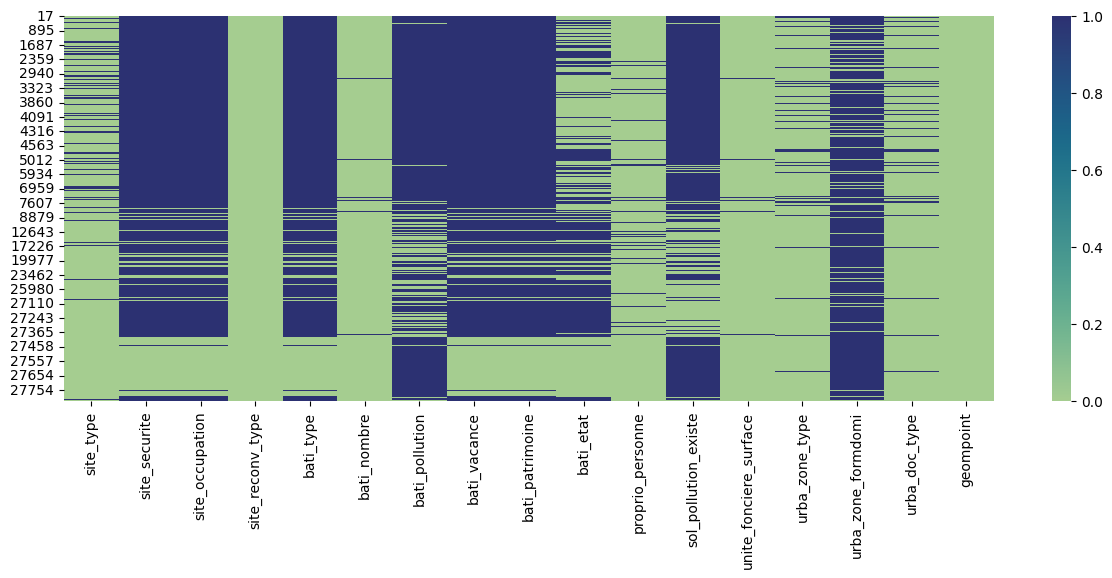

In [14]:
# Les variable dates ne sont pas correctement formatée et standardisé, un travail de nettoyage conséquent est nécessaire
df_friches_reconv = df_friches_reconv.drop(columns=['site_identif_date', 'site_actu_date', 'activite_fin_annee', 'local_ancien_annee', 'local_recent_annee'])

print(f"{df_friches_reconv.shape[0]} friches chargées — {df_friches_reconv.shape[1]} variables")
check_nan(df_friches_reconv)

## bati_patrimoine

2331 friches chargées — 16 variables
1. "urba_zone_formdomi" => 2012 NaNs (86.0%)
2. "bati_vacance" => 1901 NaNs (82.0%)
3. "site_securite" => 1892 NaNs (81.0%)
4. "site_occupation" => 1892 NaNs (81.0%)
5. "bati_type" => 1898 NaNs (81.0%)
6. "bati_pollution" => 1856 NaNs (80.0%)
7. "sol_pollution_existe" => 1685 NaNs (72.0%)
8. "bati_etat" => 1102 NaNs (47.0%)
9. "site_type" => 334 NaNs (14.0%)
10. "urba_zone_type" => 254 NaNs (11.0%)
11. "urba_doc_type" => 244 NaNs (10.0%)
12. "proprio_personne" => 169 NaNs (7.0%)
13. "bati_nombre" => 24 NaNs (1.0%)
14. "unite_fonciere_surface" => 24 NaNs (1.0%)
15. "site_reconv_type" => 0 NaNs (0.0%)
16. "geompoint" => 0 NaNs (0.0%)

Total NaNs : 15287


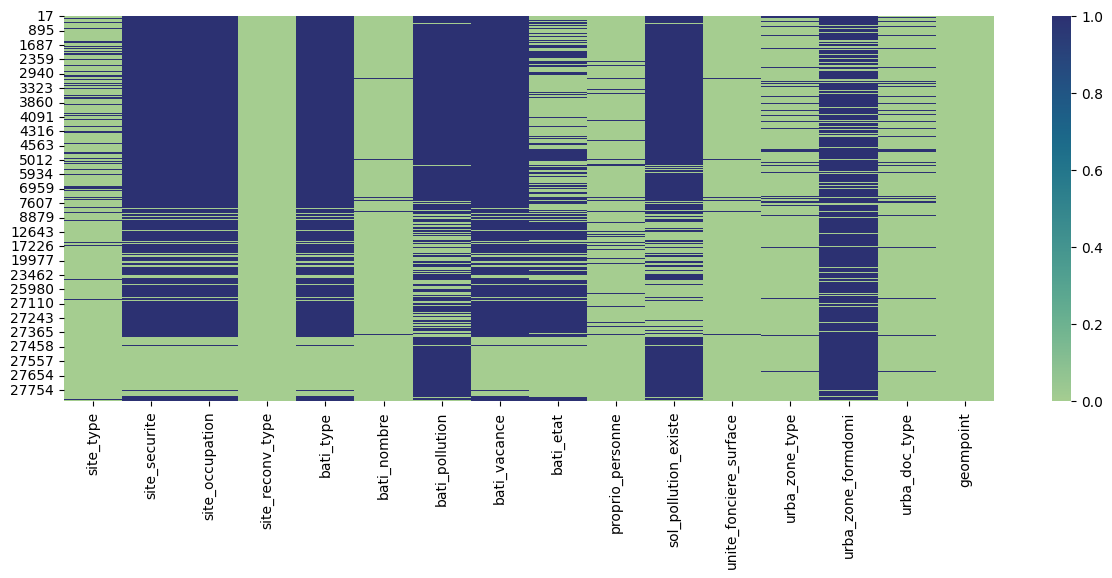

In [15]:
# Supprimer la variable bati_patrimoine du dataframe df_friches_reconv : difficilement exploitable à ce stade
df_friches_reconv = df_friches_reconv.drop(columns=['bati_patrimoine'])

print(f"{df_friches_reconv.shape[0]} friches chargées — {df_friches_reconv.shape[1]} variables")
check_nan(df_friches_reconv)

## bati_nombre

array([  2.,   0.,   3.,   1.,  nan,  32.,   5.,   6.,   4.,   9.,  10.,
         7.,  13.,  12.,  15.,  25.,  34.,  11.,  36.,  37.,  17.,  30.,
         8.,  27.,  24.,  29.,  20.,  14.,  18.,  16.,  21.,  60.,  22.,
        38.,  33.,  49.,  44.,  71., 819.,  35.,  57.,  40.])

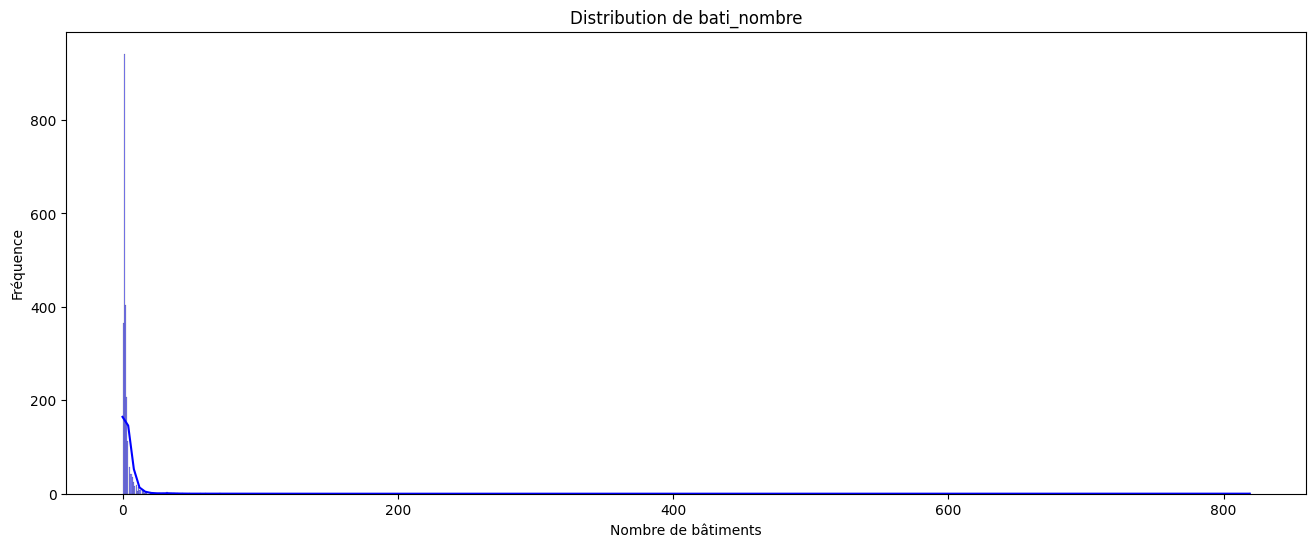

In [16]:
display(df_friches_reconv["bati_nombre"].unique())

# Créer un histogramme pour visualiser la distribution
plt.figure(figsize=(16, 6))
sns.histplot(df_friches_reconv['bati_nombre'], bins=1000, kde=True, color='blue')

# Ajouter des titres et des labels
plt.title('Distribution de bati_nombre')
plt.xlabel('Nombre de bâtiments')
plt.ylabel('Fréquence')

# Afficher le graphique
plt.show()

In [17]:
df_friches_reconv["bati_nombre"].describe()

count    2307.000000
mean        2.873862
std        17.603421
min         0.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       819.000000
Name: bati_nombre, dtype: float64

> Remplacement des valeurs manquantes par le quartile median, à savoir 1 bâtiment. Cela évite de partir sur une moyenne de 3 bâtiments biaisés par les outliers.

In [18]:
df_friches_reconv["bati_nombre"] = df_friches_reconv["bati_nombre"].fillna(1).astype(int)

display(df_friches_reconv["bati_nombre"].unique())

array([  2,   0,   3,   1,  32,   5,   6,   4,   9,  10,   7,  13,  12,
        15,  25,  34,  11,  36,  37,  17,  30,   8,  27,  24,  29,  20,
        14,  18,  16,  21,  60,  22,  38,  33,  49,  44,  71, 819,  35,
        57,  40])

## unite_fonciere_surface

array([42877.,   143., 28389., ...,   470.,  1738.,   390.], shape=(2103,))

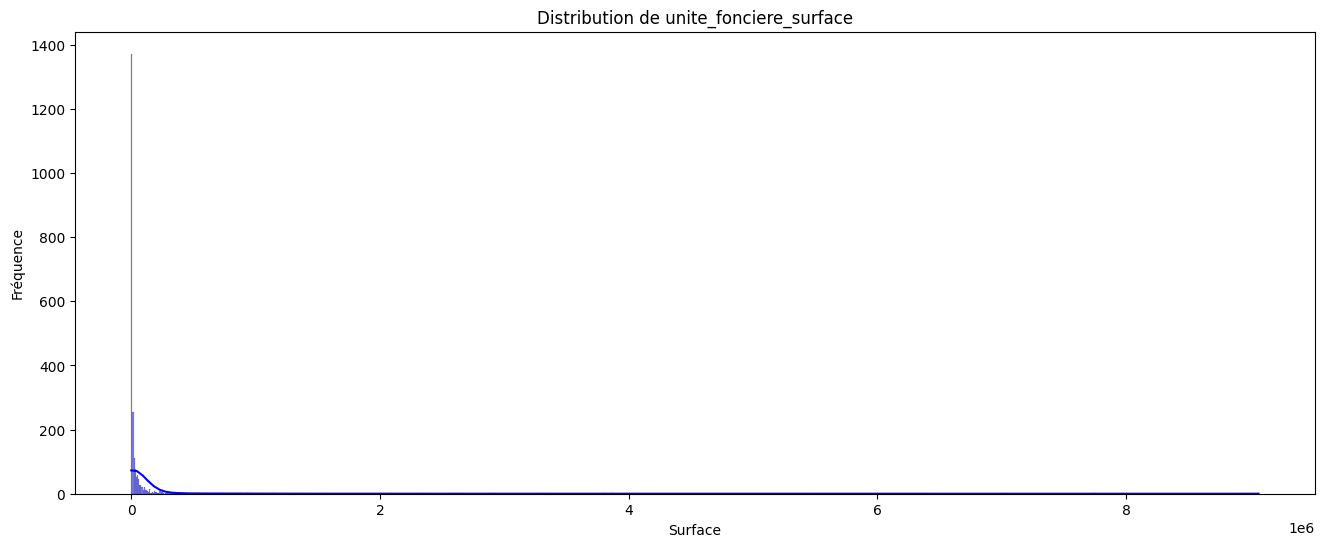

In [19]:
display(df_friches_reconv["unite_fonciere_surface"].unique())

# Créer un histogramme pour visualiser la distribution
plt.figure(figsize=(16, 6))
sns.histplot(df_friches_reconv['unite_fonciere_surface'], bins=1000, kde=True, color='blue')

# Ajouter des titres et des labels
plt.title('Distribution de unite_fonciere_surface')
plt.xlabel('Surface')
plt.ylabel('Fréquence')

# Afficher le graphique
plt.show()

In [20]:
df_friches_reconv['unite_fonciere_surface'].describe()

count    2.307000e+03
mean     9.175705e+04
std      4.812672e+05
min      1.000000e+01
25%      1.240500e+03
50%      5.149000e+03
75%      2.660700e+04
max      9.063865e+06
Name: unite_fonciere_surface, dtype: float64

> Remplacement des valeurs manquantes par le quartile median, à savoir 5m². Cela évite de partir sur une moyenne de 9m² biaisés par les outliers.

In [21]:
df_friches_reconv["unite_fonciere_surface"] = df_friches_reconv["unite_fonciere_surface"].fillna(5).astype(int)

display(df_friches_reconv["unite_fonciere_surface"].unique())

array([42877,   143, 28389, ...,   470,  1738,   390], shape=(2103,))

## geompoint

In [22]:
df_friches_reconv["geompoint"].tail()

28076      POINT (3.162491 46.99065)
28079     POINT (0.8030694 49.48767)
28080    POINT (-0.5161654 49.26891)
28081    POINT (-0.5117923 49.31289)
28102      POINT (0.135492 49.49791)
Name: geompoint, dtype: object

1. "urba_zone_formdomi" => 2012 NaNs (86.0%)
2. "bati_vacance" => 1901 NaNs (82.0%)
3. "site_securite" => 1892 NaNs (81.0%)
4. "site_occupation" => 1892 NaNs (81.0%)
5. "bati_type" => 1898 NaNs (81.0%)
6. "bati_pollution" => 1856 NaNs (80.0%)
7. "sol_pollution_existe" => 1685 NaNs (72.0%)
8. "bati_etat" => 1102 NaNs (47.0%)
9. "site_type" => 334 NaNs (14.0%)
10. "urba_zone_type" => 254 NaNs (11.0%)
11. "urba_doc_type" => 244 NaNs (10.0%)
12. "proprio_personne" => 169 NaNs (7.0%)
13. "site_reconv_type" => 0 NaNs (0.0%)
14. "bati_nombre" => 0 NaNs (0.0%)
15. "unite_fonciere_surface" => 0 NaNs (0.0%)
16. "longitude" => 0 NaNs (0.0%)
17. "latitude" => 0 NaNs (0.0%)

Total NaNs : 15239


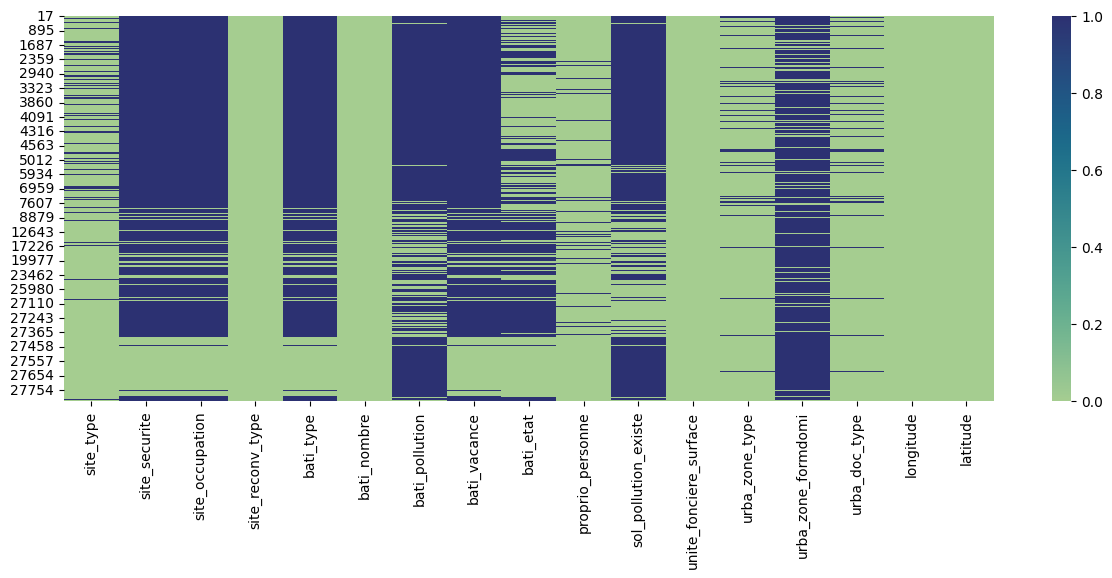

In [23]:
# Fonction pour extraire les coordonnées
def extract_coordinates(wkt_point):
    match = re.match(r'POINT \(([-+]?[\d.]+) ([-+]?[\d.]+)\)', wkt_point)
    if match:
        longitude, latitude = match.groups()
        return pd.Series({'longitude': float(longitude), 'latitude': float(latitude)})
    return pd.Series({'longitude': None, 'latitude': None})

# Appliquer la fonction pour créer de nouvelles variable
df_friches_reconv[['longitude', 'latitude']] = df_friches_reconv['geompoint'].apply(extract_coordinates)

# Supprimer geompoint
df_friches_reconv = df_friches_reconv.drop(columns=['geompoint'])

check_nan(df_friches_reconv)

## urba_zone_formdomi

1. "bati_vacance" => 1901 NaNs (82.0%)
2. "site_securite" => 1892 NaNs (81.0%)
3. "site_occupation" => 1892 NaNs (81.0%)
4. "bati_type" => 1898 NaNs (81.0%)
5. "bati_pollution" => 1856 NaNs (80.0%)
6. "sol_pollution_existe" => 1685 NaNs (72.0%)
7. "bati_etat" => 1102 NaNs (47.0%)
8. "site_type" => 334 NaNs (14.0%)
9. "urba_zone_type" => 254 NaNs (11.0%)
10. "urba_doc_type" => 244 NaNs (10.0%)
11. "proprio_personne" => 169 NaNs (7.0%)
12. "site_reconv_type" => 0 NaNs (0.0%)
13. "bati_nombre" => 0 NaNs (0.0%)
14. "unite_fonciere_surface" => 0 NaNs (0.0%)
15. "urba_zone_formdomi" => 0 NaNs (0.0%)
16. "longitude" => 0 NaNs (0.0%)
17. "latitude" => 0 NaNs (0.0%)

Total NaNs : 13227


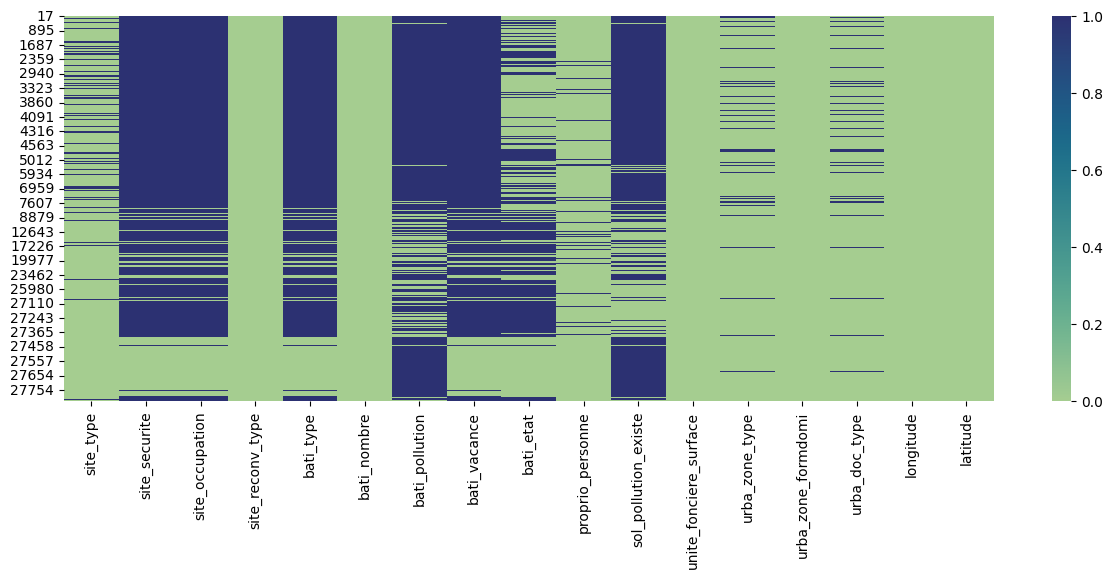

In [24]:
# Remplacement des NaN par une zone urbaine de type "Autre"
df_friches_reconv["urba_zone_formdomi"] = df_friches_reconv["urba_zone_formdomi"].fillna("Autres")

check_nan(df_friches_reconv)

In [25]:
# Appliquer One-Hot Encoding avec get_dummies
df_encoded = pd.get_dummies(df_friches_reconv, columns=['urba_zone_formdomi'])

# Identifier les colonnes issues du One-Hot Encoding
uzf_encoded_columns = df_encoded.columns[df_encoded.columns.str.startswith('urba_zone_formdomi_')]

# Convertir ces colonnes en entiers
df_encoded[uzf_encoded_columns] = df_encoded[uzf_encoded_columns].astype(int)

# Afficher le DataFrame pour vérifier l'encodage
df_encoded[uzf_encoded_columns]

,urba_zone_formdomi_Activité agricole,urba_zone_formdomi_Activité économique,urba_zone_formdomi_Autres,urba_zone_formdomi_Equipements public,urba_zone_formdomi_Espace naturel,urba_zone_formdomi_Espace remarquable,urba_zone_formdomi_Habitat,urba_zone_formdomi_Loisirs et tourisme,urba_zone_formdomi_Mixte habitat/activité,urba_zone_formdomi_Sans objet ou non encore définie dans le règlement
17,0,0,1,0,0,0,0,0,0,0
20,0,0,1,0,0,0,0,0,0,0
25,0,0,1,0,0,0,0,0,0,0
35,0,0,1,0,0,0,0,0,0,0
45,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
28076,0,0,0,0,0,0,1,0,0,0
28079,0,0,1,0,0,0,0,0,0,0
28080,0,0,0,0,0,0,1,0,0,0
28081,0,0,1,0,0,0,0,0,0,0


In [26]:
# Ajouter les données encodés
df_friches_reconv = pd.concat([df_friches_reconv, df_encoded[uzf_encoded_columns]], axis=1)
df_friches_reconv

,site_type,site_securite,site_occupation,site_reconv_type,bati_type,bati_nombre,bati_pollution,bati_vacance,bati_etat,proprio_personne,...,urba_zone_formdomi_Activité agricole,urba_zone_formdomi_Activité économique,urba_zone_formdomi_Autres,urba_zone_formdomi_Equipements public,urba_zone_formdomi_Espace naturel,urba_zone_formdomi_Espace remarquable,urba_zone_formdomi_Habitat,urba_zone_formdomi_Loisirs et tourisme,urba_zone_formdomi_Mixte habitat/activité,urba_zone_formdomi_Sans objet ou non encore définie dans le règlement
17,friche d'habitat,<NA>,<NA>,habitat,<NA>,2,<NA>,<NA>,<NA>,personne morale,...,0,0,1,0,0,0,0,0,0,0
20,friche d'habitat,NaN,<NA>,habitat,<NA>,2,<NA>,<NA>,dégradation moyenne,personne physique,...,0,0,1,0,0,0,0,0,0,0
25,friche agro-industrielle,NaN,<NA>,renaturation,<NA>,0,<NA>,<NA>,<NA>,personne physique,...,0,0,1,0,0,0,0,0,0,0
35,friche d'habitat,NaN,<NA>,équipement public,<NA>,3,<NA>,<NA>,dégradation moyenne,personne physique,...,0,0,1,0,0,0,0,0,0,0
45,friche agro-industrielle,NaN,<NA>,renaturation,<NA>,0,<NA>,<NA>,<NA>,personne physique,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28076,friche d'habitat,<NA>,<NA>,mixte,<NA>,1,amiante,<NA>,<NA>,personne morale,...,0,0,0,0,0,0,1,0,0,0
28079,friche d'équipement public,NaN,<NA>,équipement public,<NA>,6,<NA>,<NA>,dégradation très importante,personne morale,...,0,0,1,0,0,0,0,0,0,0
28080,friche d'habitat,NaN,<NA>,équipement public,<NA>,3,<NA>,<NA>,dégradation très importante,personne physique,...,0,0,0,0,0,0,1,0,0,0
28081,friche d'habitat,NaN,<NA>,aménagement d'espace public,<NA>,0,<NA>,<NA>,dégradation très importante,personne physique,...,0,0,1,0,0,0,0,0,0,0


1. "bati_vacance" => 1901 NaNs (82.0%)
2. "site_securite" => 1892 NaNs (81.0%)
3. "site_occupation" => 1892 NaNs (81.0%)
4. "bati_type" => 1898 NaNs (81.0%)
5. "bati_pollution" => 1856 NaNs (80.0%)
6. "sol_pollution_existe" => 1685 NaNs (72.0%)
7. "bati_etat" => 1102 NaNs (47.0%)
8. "site_type" => 334 NaNs (14.0%)
9. "urba_zone_type" => 254 NaNs (11.0%)
10. "urba_doc_type" => 244 NaNs (10.0%)
11. "proprio_personne" => 169 NaNs (7.0%)
12. "site_reconv_type" => 0 NaNs (0.0%)
13. "bati_nombre" => 0 NaNs (0.0%)
14. "unite_fonciere_surface" => 0 NaNs (0.0%)
15. "longitude" => 0 NaNs (0.0%)
16. "latitude" => 0 NaNs (0.0%)
17. "urba_zone_formdomi_Activité agricole" => 0 NaNs (0.0%)
18. "urba_zone_formdomi_Activité économique" => 0 NaNs (0.0%)
19. "urba_zone_formdomi_Autres" => 0 NaNs (0.0%)
20. "urba_zone_formdomi_Equipements public" => 0 NaNs (0.0%)
21. "urba_zone_formdomi_Espace naturel" => 0 NaNs (0.0%)
22. "urba_zone_formdomi_Espace remarquable" => 0 NaNs (0.0%)
23. "urba_zone_formdomi_Ha

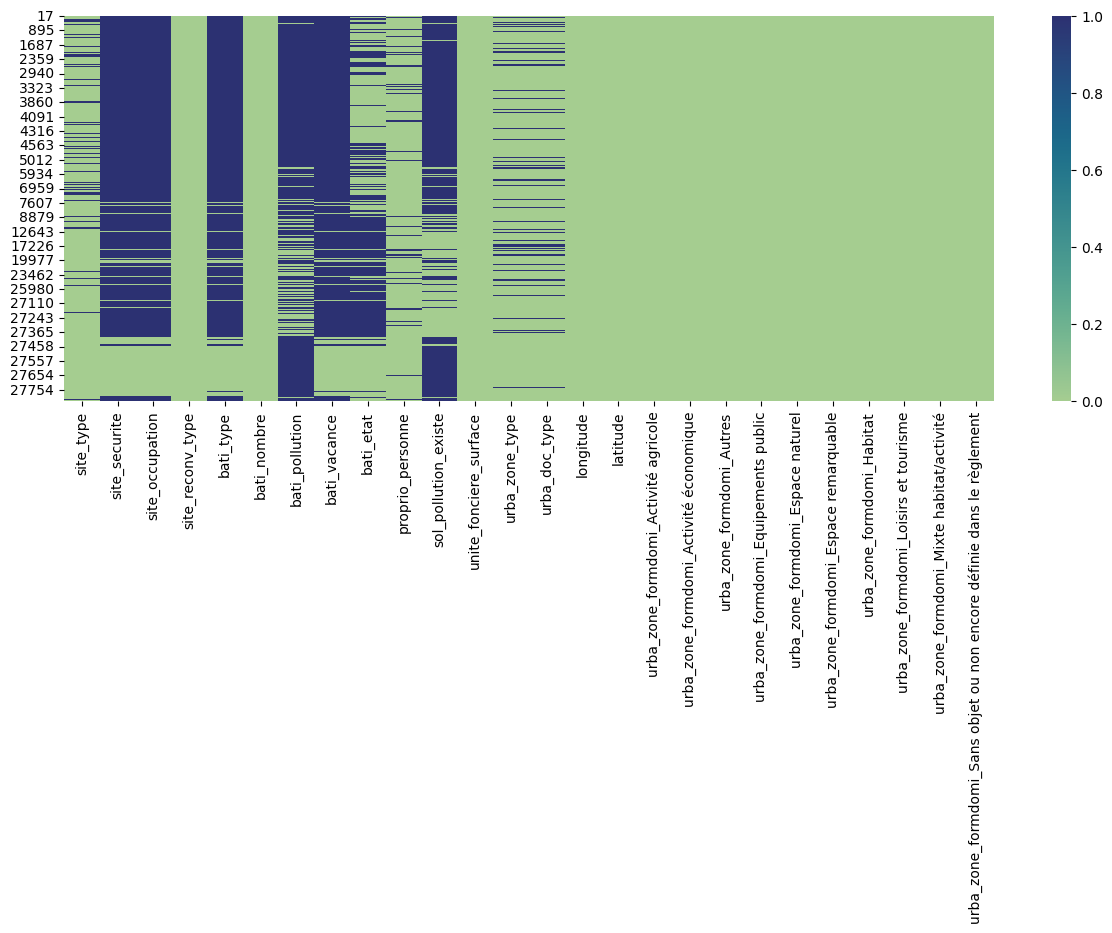

In [27]:
# Supprimer urba_zone_formdomi
df_friches_reconv = df_friches_reconv.drop(columns=['urba_zone_formdomi'])

check_nan(df_friches_reconv)

## site_securite

In [28]:
df_friches_reconv["site_securite"].unique()

array([<NA>, nan,
       'évacuation des produits dangereux et déchets présents sur le site'],
      dtype=object)

In [29]:
# Determiner et encoder si la friche est assurément sécurisée
df_friches_reconv["site_securite"] = df_friches_reconv["site_securite"].replace('évacuation des produits dangereux et déchets présents sur le site', '1')
df_friches_reconv["site_securite"] = df_friches_reconv["site_securite"].fillna("0")

df_friches_reconv["site_securite"] = df_friches_reconv["site_securite"].astype(int)

df_friches_reconv["site_securite"]

17       0
20       0
25       0
35       0
45       0
        ..
28076    0
28079    0
28080    0
28081    0
28102    0
Name: site_securite, Length: 2331, dtype: int64

1. "bati_vacance" => 1901 NaNs (82.0%)
2. "site_occupation" => 1892 NaNs (81.0%)
3. "bati_type" => 1898 NaNs (81.0%)
4. "bati_pollution" => 1856 NaNs (80.0%)
5. "sol_pollution_existe" => 1685 NaNs (72.0%)
6. "bati_etat" => 1102 NaNs (47.0%)
7. "site_type" => 334 NaNs (14.0%)
8. "urba_zone_type" => 254 NaNs (11.0%)
9. "urba_doc_type" => 244 NaNs (10.0%)
10. "proprio_personne" => 169 NaNs (7.0%)
11. "site_securite" => 0 NaNs (0.0%)
12. "site_reconv_type" => 0 NaNs (0.0%)
13. "bati_nombre" => 0 NaNs (0.0%)
14. "unite_fonciere_surface" => 0 NaNs (0.0%)
15. "longitude" => 0 NaNs (0.0%)
16. "latitude" => 0 NaNs (0.0%)
17. "urba_zone_formdomi_Activité agricole" => 0 NaNs (0.0%)
18. "urba_zone_formdomi_Activité économique" => 0 NaNs (0.0%)
19. "urba_zone_formdomi_Autres" => 0 NaNs (0.0%)
20. "urba_zone_formdomi_Equipements public" => 0 NaNs (0.0%)
21. "urba_zone_formdomi_Espace naturel" => 0 NaNs (0.0%)
22. "urba_zone_formdomi_Espace remarquable" => 0 NaNs (0.0%)
23. "urba_zone_formdomi_Habita

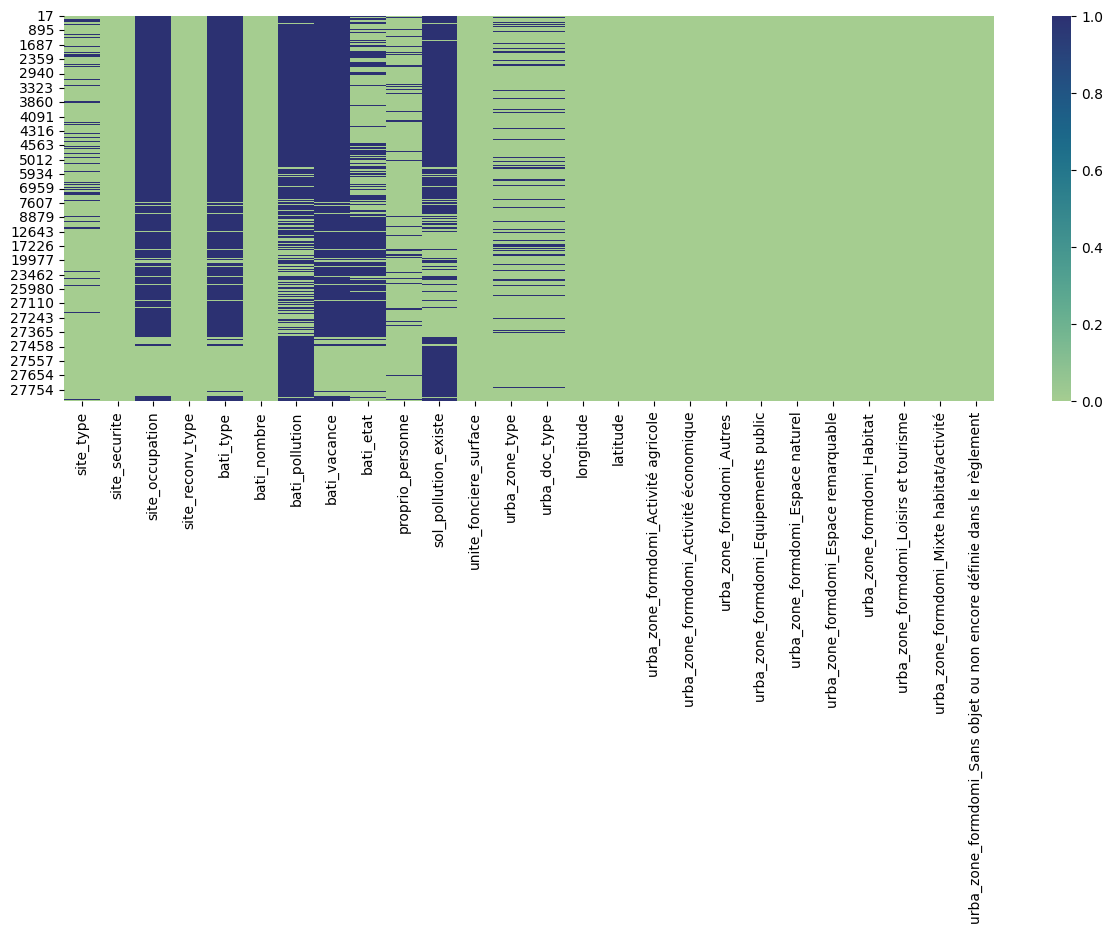

In [30]:
check_nan(df_friches_reconv)

## site_occupation

In [31]:
print(df_friches_reconv["site_occupation"].unique())
print(df_friches_reconv["site_occupation"].isna().sum())


[<NA> "friche d'habitat" 'friche commerciale' 'friche industrielle'
 'friche hospitalière' 'mixte' "friche d'équipement public"
 'friche carrière ou mine' 'friche loisir tourisme hôtellerie'
 'friche cultuelle' 'friche agro-industrielle' 'friche logistique']
1892


> Création d'une categorie "friche_non_occupee" pour les valeurs manquantes.

In [32]:
df_friches_reconv["site_occupation"] = df_friches_reconv["site_occupation"].fillna("friche_non_occupee")
print(df_friches_reconv["site_occupation"].isna().sum())

0


In [33]:
# Appliquer One-Hot Encoding avec get_dummies
df_encoded = pd.get_dummies(df_friches_reconv, columns=['site_occupation'])

# Identifier les colonnes issues du One-Hot Encoding
so_encoded_columns = df_encoded.columns[df_encoded.columns.str.startswith('site_occupation_')]

# Convertir ces colonnes en entiers
df_encoded[so_encoded_columns] = df_encoded[so_encoded_columns].astype(int)

# Afficher le DataFrame pour vérifier l'encodage
df_encoded[so_encoded_columns]

,site_occupation_friche agro-industrielle,site_occupation_friche carrière ou mine,site_occupation_friche commerciale,site_occupation_friche cultuelle,site_occupation_friche d'habitat,site_occupation_friche d'équipement public,site_occupation_friche hospitalière,site_occupation_friche industrielle,site_occupation_friche logistique,site_occupation_friche loisir tourisme hôtellerie,site_occupation_friche_non_occupee,site_occupation_mixte
17,0,0,0,0,0,0,0,0,0,0,1,0
20,0,0,0,0,0,0,0,0,0,0,1,0
25,0,0,0,0,0,0,0,0,0,0,1,0
35,0,0,0,0,0,0,0,0,0,0,1,0
45,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
28076,0,0,0,0,0,0,0,0,0,0,1,0
28079,0,0,0,0,0,0,0,0,0,0,1,0
28080,0,0,0,0,0,0,0,0,0,0,1,0
28081,0,0,0,0,0,0,0,0,0,0,1,0


In [34]:
# Supprimer site_occupation
df_friches_reconv = df_friches_reconv.drop(columns=['site_occupation'])

# Ajouter les données encodés
df_friches_reconv = pd.concat([df_friches_reconv, df_encoded[so_encoded_columns]], axis=1)
df_friches_reconv

,site_type,site_securite,site_reconv_type,bati_type,bati_nombre,bati_pollution,bati_vacance,bati_etat,proprio_personne,sol_pollution_existe,...,site_occupation_friche commerciale,site_occupation_friche cultuelle,site_occupation_friche d'habitat,site_occupation_friche d'équipement public,site_occupation_friche hospitalière,site_occupation_friche industrielle,site_occupation_friche logistique,site_occupation_friche loisir tourisme hôtellerie,site_occupation_friche_non_occupee,site_occupation_mixte
17,friche d'habitat,0,habitat,<NA>,2,<NA>,<NA>,<NA>,personne morale,pollution peu probable,...,0,0,0,0,0,0,0,0,1,0
20,friche d'habitat,0,habitat,<NA>,2,<NA>,<NA>,dégradation moyenne,personne physique,<NA>,...,0,0,0,0,0,0,0,0,1,0
25,friche agro-industrielle,0,renaturation,<NA>,0,<NA>,<NA>,<NA>,personne physique,<NA>,...,0,0,0,0,0,0,0,0,1,0
35,friche d'habitat,0,équipement public,<NA>,3,<NA>,<NA>,dégradation moyenne,personne physique,<NA>,...,0,0,0,0,0,0,0,0,1,0
45,friche agro-industrielle,0,renaturation,<NA>,0,<NA>,<NA>,<NA>,personne physique,<NA>,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28076,friche d'habitat,0,mixte,<NA>,1,amiante,<NA>,<NA>,personne morale,pollution peu probable,...,0,0,0,0,0,0,0,0,1,0
28079,friche d'équipement public,0,équipement public,<NA>,6,<NA>,<NA>,dégradation très importante,personne morale,<NA>,...,0,0,0,0,0,0,0,0,1,0
28080,friche d'habitat,0,équipement public,<NA>,3,<NA>,<NA>,dégradation très importante,personne physique,<NA>,...,0,0,0,0,0,0,0,0,1,0
28081,friche d'habitat,0,aménagement d'espace public,<NA>,0,<NA>,<NA>,dégradation très importante,personne physique,<NA>,...,0,0,0,0,0,0,0,0,1,0


## bati_type

array([<NA>, 'résidentiel', 'commercial', 'industriel',
       'secteur tertiaire'], dtype=object)

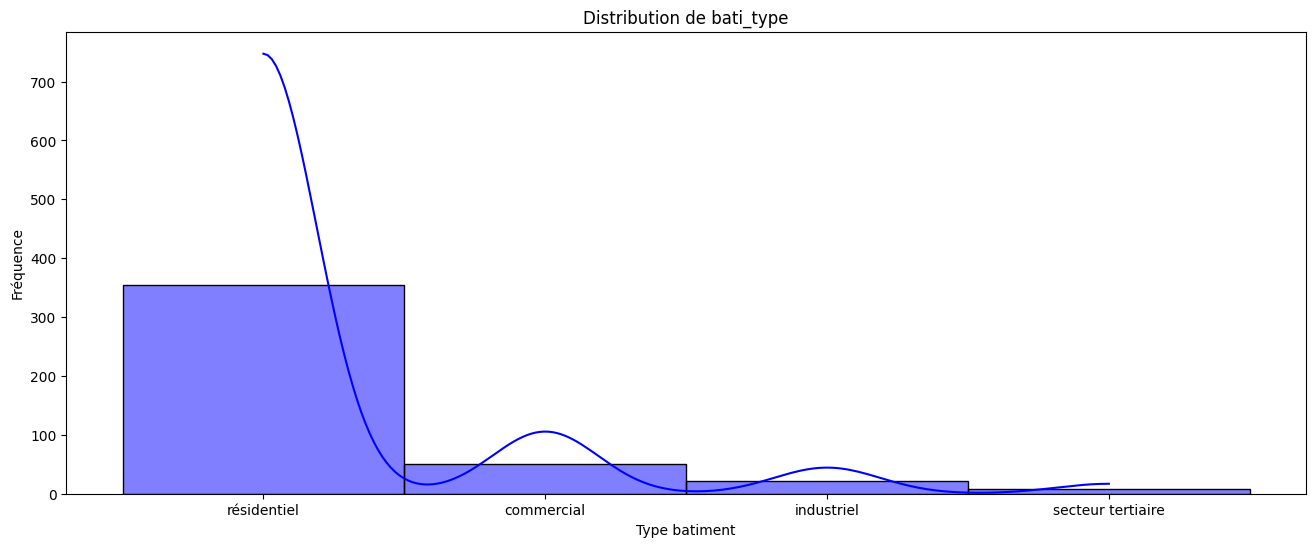

In [35]:
display(df_friches_reconv["bati_type"].unique())

# Créer un histogramme pour visualiser la distribution
plt.figure(figsize=(16, 6))
sns.histplot(df_friches_reconv['bati_type'], bins=1, kde=True, color='blue')

# Ajouter des titres et des labels
plt.title('Distribution de bati_type')
plt.xlabel('Type batiment')
plt.ylabel('Fréquence')

# Afficher le graphique
plt.show()

> Création d'une valeur "inconnu"

In [36]:
df_friches_reconv["bati_type"] = df_friches_reconv["bati_type"].fillna("inconnu")
print(df_friches_reconv["bati_type"].isna().sum())

0


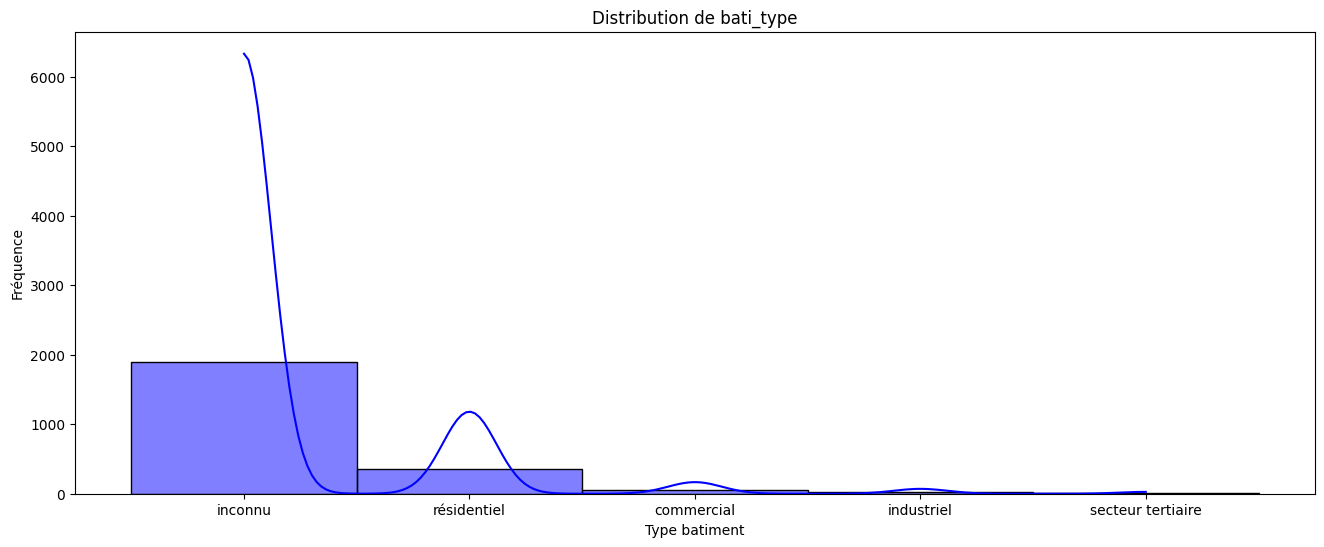

In [37]:
# Créer un histogramme pour visualiser la distribution
plt.figure(figsize=(16, 6))
sns.histplot(df_friches_reconv['bati_type'], bins=1, kde=True, color='blue')

# Ajouter des titres et des labels
plt.title('Distribution de bati_type')
plt.xlabel('Type batiment')
plt.ylabel('Fréquence')

# Afficher le graphique
plt.show()

In [38]:
# Appliquer One-Hot Encoding avec get_dummies
df_encoded = pd.get_dummies(df_friches_reconv, columns=['bati_type'])

# Identifier les colonnes issues du One-Hot Encoding
bati_type_encoded_columns = df_encoded.columns[df_encoded.columns.str.startswith('bati_type_')]

# Convertir ces colonnes en entiers
df_encoded[bati_type_encoded_columns] = df_encoded[bati_type_encoded_columns].astype(int)

# Afficher le DataFrame pour vérifier l'encodage
df_encoded[bati_type_encoded_columns]

,bati_type_commercial,bati_type_inconnu,bati_type_industriel,bati_type_résidentiel,bati_type_secteur tertiaire
17,0,1,0,0,0
20,0,1,0,0,0
25,0,1,0,0,0
35,0,1,0,0,0
45,0,1,0,0,0
...,...,...,...,...,...
28076,0,1,0,0,0
28079,0,1,0,0,0
28080,0,1,0,0,0
28081,0,1,0,0,0


In [39]:
# Supprimer bati_type
df_friches_reconv = df_friches_reconv.drop(columns=['bati_type'])

# Ajouter les données encodés
df_friches_reconv = pd.concat([df_friches_reconv, df_encoded[bati_type_encoded_columns]], axis=1)
df_friches_reconv

,site_type,site_securite,site_reconv_type,bati_nombre,bati_pollution,bati_vacance,bati_etat,proprio_personne,sol_pollution_existe,unite_fonciere_surface,...,site_occupation_friche industrielle,site_occupation_friche logistique,site_occupation_friche loisir tourisme hôtellerie,site_occupation_friche_non_occupee,site_occupation_mixte,bati_type_commercial,bati_type_inconnu,bati_type_industriel,bati_type_résidentiel,bati_type_secteur tertiaire
17,friche d'habitat,0,habitat,2,<NA>,<NA>,<NA>,personne morale,pollution peu probable,42877,...,0,0,0,1,0,0,1,0,0,0
20,friche d'habitat,0,habitat,2,<NA>,<NA>,dégradation moyenne,personne physique,<NA>,143,...,0,0,0,1,0,0,1,0,0,0
25,friche agro-industrielle,0,renaturation,0,<NA>,<NA>,<NA>,personne physique,<NA>,28389,...,0,0,0,1,0,0,1,0,0,0
35,friche d'habitat,0,équipement public,3,<NA>,<NA>,dégradation moyenne,personne physique,<NA>,2619,...,0,0,0,1,0,0,1,0,0,0
45,friche agro-industrielle,0,renaturation,0,<NA>,<NA>,<NA>,personne physique,<NA>,60709,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28076,friche d'habitat,0,mixte,1,amiante,<NA>,<NA>,personne morale,pollution peu probable,470,...,0,0,0,1,0,0,1,0,0,0
28079,friche d'équipement public,0,équipement public,6,<NA>,<NA>,dégradation très importante,personne morale,<NA>,4744834,...,0,0,0,1,0,0,1,0,0,0
28080,friche d'habitat,0,équipement public,3,<NA>,<NA>,dégradation très importante,personne physique,<NA>,1738,...,0,0,0,1,0,0,1,0,0,0
28081,friche d'habitat,0,aménagement d'espace public,0,<NA>,<NA>,dégradation très importante,personne physique,<NA>,390,...,0,0,0,1,0,0,1,0,0,0


## bati_vacance

array([<NA>, 'occupé', 'vacant', 'partiellement occupé'], dtype=object)

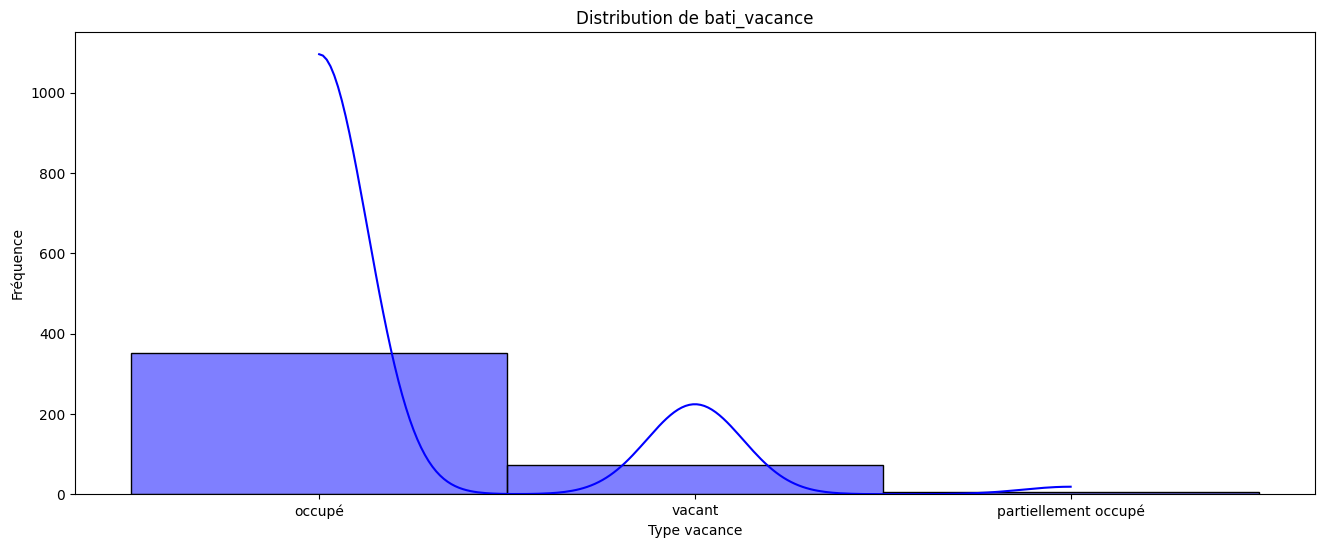

In [40]:
display(df_friches_reconv["bati_vacance"].unique())

# Créer un histogramme pour visualiser la distribution
plt.figure(figsize=(16, 6))
sns.histplot(df_friches_reconv['bati_vacance'], bins=1, kde=True, color='blue')

# Ajouter des titres et des labels
plt.title('Distribution de bati_vacance')
plt.xlabel('Type vacance')
plt.ylabel('Fréquence')

# Afficher le graphique
plt.show()

> Partons du principe que les valeurs manquantes signifie que la friche est **vacante**.

0


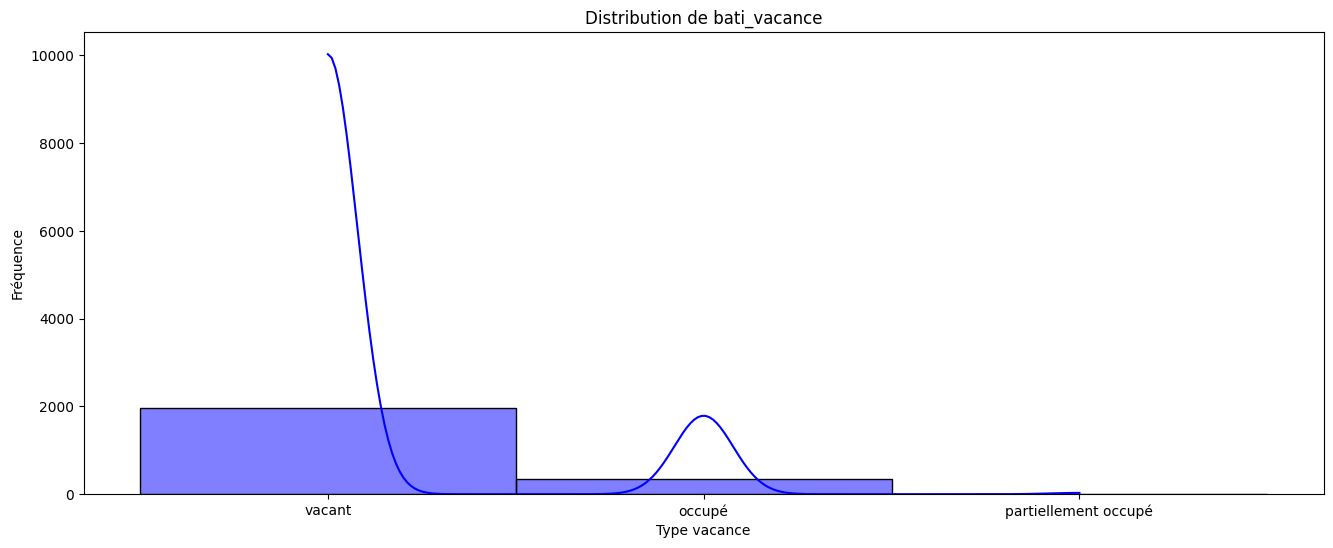

In [41]:
df_friches_reconv["bati_vacance"] = df_friches_reconv["bati_vacance"].fillna("vacant")

print(df_friches_reconv["bati_vacance"].isna().sum())

# Créer un histogramme pour visualiser la distribution
plt.figure(figsize=(16, 6))
sns.histplot(df_friches_reconv['bati_vacance'], bins=1, kde=True, color='blue')

# Ajouter des titres et des labels
plt.title('Distribution de bati_vacance')
plt.xlabel('Type vacance')
plt.ylabel('Fréquence')

# Afficher le graphique
plt.show()





In [42]:
# Appliquer One-Hot Encoding avec get_dummies
df_encoded = pd.get_dummies(df_friches_reconv, columns=['bati_vacance'])

# Identifier les colonnes issues du One-Hot Encoding
vacance_encoded_columns = df_encoded.columns[df_encoded.columns.str.startswith('bati_vacance_')]

# Convertir ces colonnes en entiers
df_encoded[vacance_encoded_columns] = df_encoded[vacance_encoded_columns].astype(int)

# Afficher le DataFrame pour vérifier l'encodage
df_encoded[vacance_encoded_columns]

,bati_vacance_occupé,bati_vacance_partiellement occupé,bati_vacance_vacant
17,0,0,1
20,0,0,1
25,0,0,1
35,0,0,1
45,0,0,1
...,...,...,...
28076,0,0,1
28079,0,0,1
28080,0,0,1
28081,0,0,1


In [43]:
# Supprimer bati_vacance
df_friches_reconv = df_friches_reconv.drop(columns=['bati_vacance'])

# Ajouter les données encodés
df_friches_reconv = pd.concat([df_friches_reconv, df_encoded[vacance_encoded_columns]], axis=1)
df_friches_reconv

,site_type,site_securite,site_reconv_type,bati_nombre,bati_pollution,bati_etat,proprio_personne,sol_pollution_existe,unite_fonciere_surface,urba_zone_type,...,site_occupation_friche_non_occupee,site_occupation_mixte,bati_type_commercial,bati_type_inconnu,bati_type_industriel,bati_type_résidentiel,bati_type_secteur tertiaire,bati_vacance_occupé,bati_vacance_partiellement occupé,bati_vacance_vacant
17,friche d'habitat,0,habitat,2,<NA>,<NA>,personne morale,pollution peu probable,42877,U,...,1,0,0,1,0,0,0,0,0,1
20,friche d'habitat,0,habitat,2,<NA>,dégradation moyenne,personne physique,<NA>,143,NaN,...,1,0,0,1,0,0,0,0,0,1
25,friche agro-industrielle,0,renaturation,0,<NA>,<NA>,personne physique,<NA>,28389,N,...,1,0,0,1,0,0,0,0,0,1
35,friche d'habitat,0,équipement public,3,<NA>,dégradation moyenne,personne physique,<NA>,2619,NaN,...,1,0,0,1,0,0,0,0,0,1
45,friche agro-industrielle,0,renaturation,0,<NA>,<NA>,personne physique,<NA>,60709,A,...,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28076,friche d'habitat,0,mixte,1,amiante,<NA>,personne morale,pollution peu probable,470,U,...,1,0,0,1,0,0,0,0,0,1
28079,friche d'équipement public,0,équipement public,6,<NA>,dégradation très importante,personne morale,<NA>,4744834,U,...,1,0,0,1,0,0,0,0,0,1
28080,friche d'habitat,0,équipement public,3,<NA>,dégradation très importante,personne physique,<NA>,1738,U,...,1,0,0,1,0,0,0,0,0,1
28081,friche d'habitat,0,aménagement d'espace public,0,<NA>,dégradation très importante,personne physique,<NA>,390,U,...,1,0,0,1,0,0,0,0,0,1


## bati_pollution [TODO]

In [44]:
df_friches_reconv["bati_pollution"].unique()

array([<NA>, 'amiante', 'plomb'], dtype=object)

## bati_etat [TODO]

In [45]:
df_friches_reconv["bati_etat"].unique()

array([<NA>, 'dégradation moyenne', 'dégradation très importante',
       'sans objet', 'dégradation inexistante ou faible'], dtype=object)

## sol_pollution_existe [TODO]

In [46]:
df_friches_reconv["sol_pollution_existe"].unique()

array(['pollution peu probable', <NA>, 'pollution avérée',
       'pollution supposée', 'pollution inexistante', 'pollution traitée'],
      dtype=object)

## urba_zone_type [TODO]

In [47]:
df_friches_reconv["urba_zone_type"].unique()

array(['U', nan, 'N', 'A', 'AUc', 'ZnC', 'ZC', 'AUs', 'ZCa'], dtype=object)

## urba_doc_type [TODO]

In [48]:
df_friches_reconv["urba_doc_type"].unique()

array(['PLUI', 'PLU', nan, 'CC', 'PSMV', <NA>], dtype=object)

## site_type [TODO]

In [49]:
df_friches_reconv["site_type"].unique()

array(["friche d'habitat", 'friche agro-industrielle',
       'friche logistique', 'friche industrielle', 'friche commerciale',
       <NA>, 'mixte', "friche d'équipement public",
       'friche loisir tourisme hôtellerie', 'friche ferroviaire',
       'friche carrière ou mine', 'friche militaire',
       'friche hospitalière', 'friche portuaire', 'friche enseignement',
       'friche cultuelle'], dtype=object)

## proprio_personne [TODO]

In [50]:
df_friches_reconv["proprio_personne"].unique()

array(['personne morale', 'personne physique', nan, <NA>], dtype=object)

# Suppression des friches sans interêt

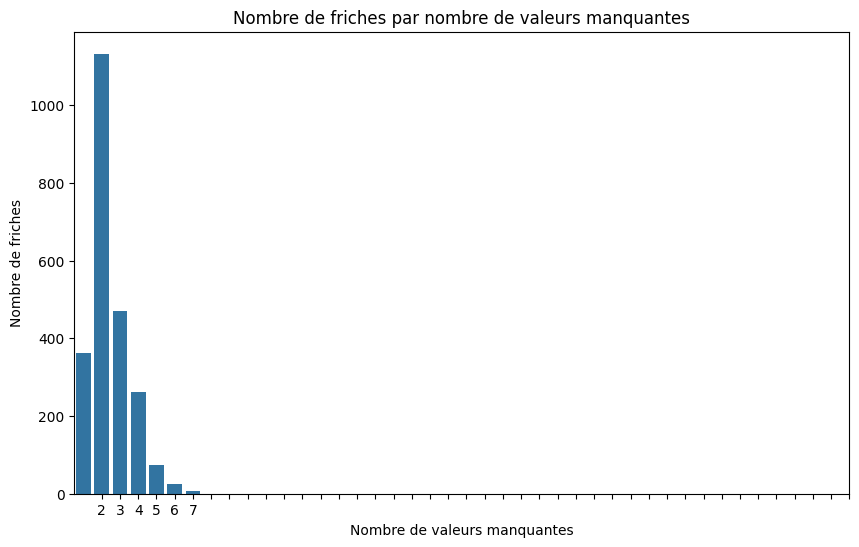

In [51]:
# Filtrer les friches sans interêts, ne possédant que très peu d'informations
friches_vides_sum = df_friches_reconv.isna().sum(axis=1)
comptes = friches_vides_sum.value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=comptes.index, y=comptes.values)
plt.title('Nombre de friches par nombre de valeurs manquantes')
plt.xlabel('Nombre de valeurs manquantes')
plt.ylabel('Nombre de friches')
plt.xticks(range(1, df_friches_reconv.shape[1]))
plt.show()

In [52]:
# Fixons le seuil de tolérance arbitrairement
seuil = int(df_friches_reconv.shape[1]/2)
print(f"Sur les {df_friches_reconv.shape[0]} friches, {df_friches_reconv[friches_vides_sum > seuil].shape[0]} friches sont sans interêt.")

Sur les 2331 friches, 0 friches sont sans interêt.


In [53]:
# Supprimer ces friches sans interêt
friches_sans_interet = df_friches_reconv[friches_vides_sum > seuil].index
df_friches_reconv = df_friches_reconv.drop(friches_sans_interet)
print(f"{df_friches_reconv.shape[0]} friches chargées — {df_friches_reconv.shape[1]} variables")

2331 friches chargées — 43 variables


# Renommer les variables (snake_case)

In [54]:
df_friches_reconv = df_friches_reconv.rename(columns=lambda x: x.lower().replace(' ', '_').replace('/', '_').replace('-', '_').replace('\'', '_').replace('é', 'e').replace('è', 'e').replace('o', 'o').replace('urba_zone_formdomi', 'uzf').replace('site_occupation', 'so'))
df_friches_reconv.dtypes

site_type                                                  object
site_securite                                               int64
site_reconv_type                                           object
bati_nombre                                                 int64
bati_pollution                                             object
bati_etat                                                  object
proprio_personne                                           object
sol_pollution_existe                                       object
unite_fonciere_surface                                      int64
urba_zone_type                                             object
urba_doc_type                                              object
longitude                                                 float64
latitude                                                  float64
uzf_activite_agricole                                       int64
uzf_activite_economique                                     int64
uzf_autres

# Analyse de la variable cible

In [55]:
print(f"{df_friches_reconv['site_reconv_type'].describe().unique()[1]} valeurs dans la variable cible dans les données de data.gouv.fr (CNIG) :")

for item in df_friches_reconv['site_reconv_type'].unique() :
    print(item)

display(df_friches_reconv['site_reconv_type'].describe())

11 valeurs dans la variable cible dans les données de data.gouv.fr (CNIG) :
habitat
renaturation
équipement public
mixte
autres activités économiques
aménagement d'espace public
commerce
panneaux photovoltaiques
�nergie, hors photovoltaique
bureau
industrie


count        2331
unique         11
top       habitat
freq         1100
Name: site_reconv_type, dtype: object

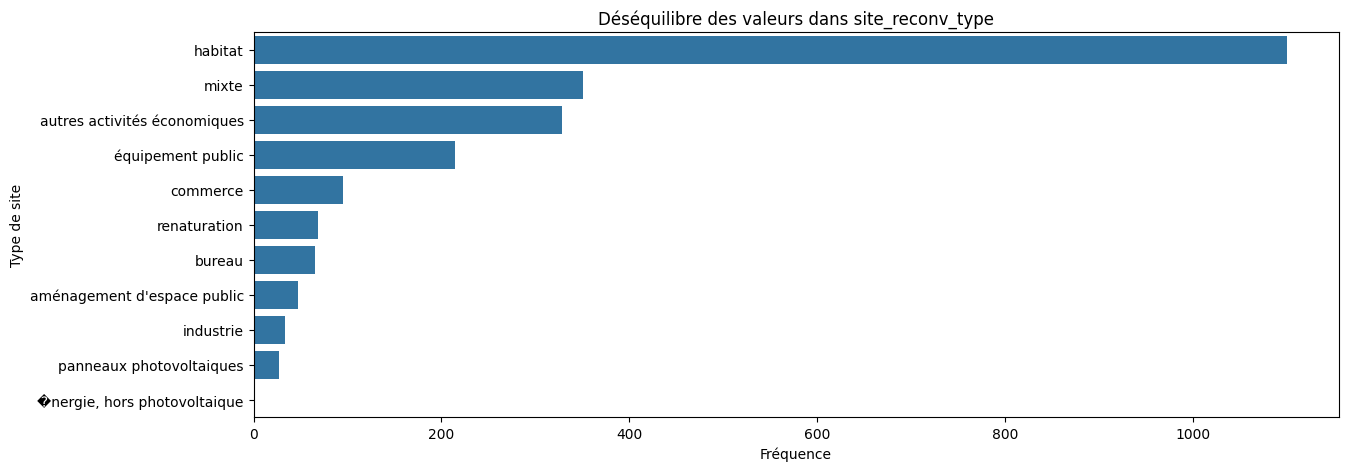

In [56]:
# Créer un diagramme en barres pour visualiser la distribution des catégories
plt.figure(figsize=(14, 5))
sns.countplot(data=df_friches_reconv, y='site_reconv_type', order=df_friches_reconv['site_reconv_type'].value_counts().index)

# Ajouter des titres et des labels
plt.title('Déséquilibre des valeurs dans site_reconv_type')
plt.xlabel('Fréquence')
plt.ylabel('Type de site')

# Afficher le graphique
plt.show()

> Nous pouvons constater un fort désequilibre en faveur des friches reconverties en **HABITAT**, c'est à prendre en compte.

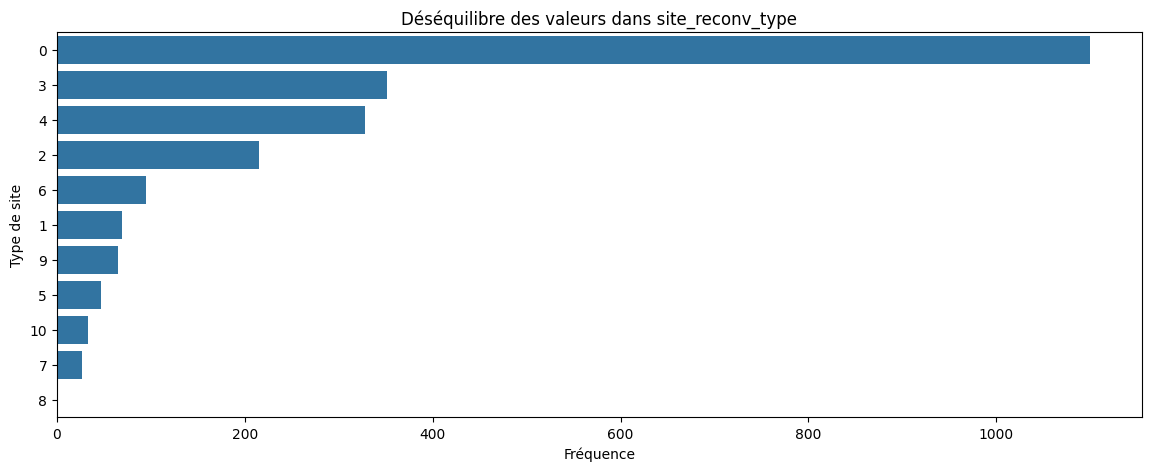

In [57]:
# Encoder les valeurs
dict_reconv = {
    "habitat": 0,
    "renaturation": 1,
    "équipement public": 2,
    "mixte": 3,
    "autres activités économiques": 4,
    "aménagement d'espace public": 5,
    "commerce": 6,
    "panneaux photovoltaiques": 7,
    "�nergie, hors photovoltaique": 8,
    "bureau": 9,
    "industrie": 10
}

# Remplacement des valeurs
df_friches_reconv['site_reconv_type'] = df_friches_reconv['site_reconv_type'].map(dict_reconv).astype(int)

# Créer un diagramme en barres pour visualiser la distribution des catégories
plt.figure(figsize=(14, 5))
sns.countplot(data=df_friches_reconv, y='site_reconv_type', order=df_friches_reconv['site_reconv_type'].value_counts().index)

# Ajouter des titres et des labels
plt.title('Déséquilibre des valeurs dans site_reconv_type')
plt.xlabel('Fréquence')
plt.ylabel('Type de site')

# Afficher le graphique
plt.show()

In [58]:
df_friches_reconv['site_reconv_type'].value_counts()

site_reconv_type
0     1100
3      351
4      328
2      215
6       95
1       69
9       65
5       47
10      33
7       27
8        1
Name: count, dtype: int64

# Export des données pour l'entrainement

,Manquantes,(%),Type,Uniques
site_securite,0,0.00,int64,2
site_reconv_type,0,0.00,int64,11
bati_nombre,0,0.00,int64,41
uzf_activite_economique,0,0.00,int64,2
latitude,0,0.00,float64,2297
uzf_activite_agricole,0,0.00,int64,2
longitude,0,0.00,float64,2322
unite_fonciere_surface,0,0.00,int64,2103
uzf_autres,0,0.00,int64,2
uzf_sans_objet_ou_non_encore_definie_dans_le_reglement,0,0.00,int64,2


1. "bati_pollution" => 1856 NaNs (80.0%)
2. "sol_pollution_existe" => 1685 NaNs (72.0%)
3. "bati_etat" => 1102 NaNs (47.0%)
4. "site_type" => 334 NaNs (14.0%)
5. "urba_zone_type" => 254 NaNs (11.0%)
6. "urba_doc_type" => 244 NaNs (10.0%)
7. "proprio_personne" => 169 NaNs (7.0%)
8. "site_securite" => 0 NaNs (0.0%)
9. "site_reconv_type" => 0 NaNs (0.0%)
10. "bati_nombre" => 0 NaNs (0.0%)
11. "unite_fonciere_surface" => 0 NaNs (0.0%)
12. "longitude" => 0 NaNs (0.0%)
13. "latitude" => 0 NaNs (0.0%)
14. "uzf_activite_agricole" => 0 NaNs (0.0%)
15. "uzf_activite_economique" => 0 NaNs (0.0%)
16. "uzf_autres" => 0 NaNs (0.0%)
17. "uzf_equipements_public" => 0 NaNs (0.0%)
18. "uzf_espace_naturel" => 0 NaNs (0.0%)
19. "uzf_espace_remarquable" => 0 NaNs (0.0%)
20. "uzf_habitat" => 0 NaNs (0.0%)
21. "uzf_loisirs_et_tourisme" => 0 NaNs (0.0%)
22. "uzf_mixte_habitat_activite" => 0 NaNs (0.0%)
23. "uzf_sans_objet_ou_non_encore_definie_dans_le_reglement" => 0 NaNs (0.0%)
24. "so_friche_agro_industriel

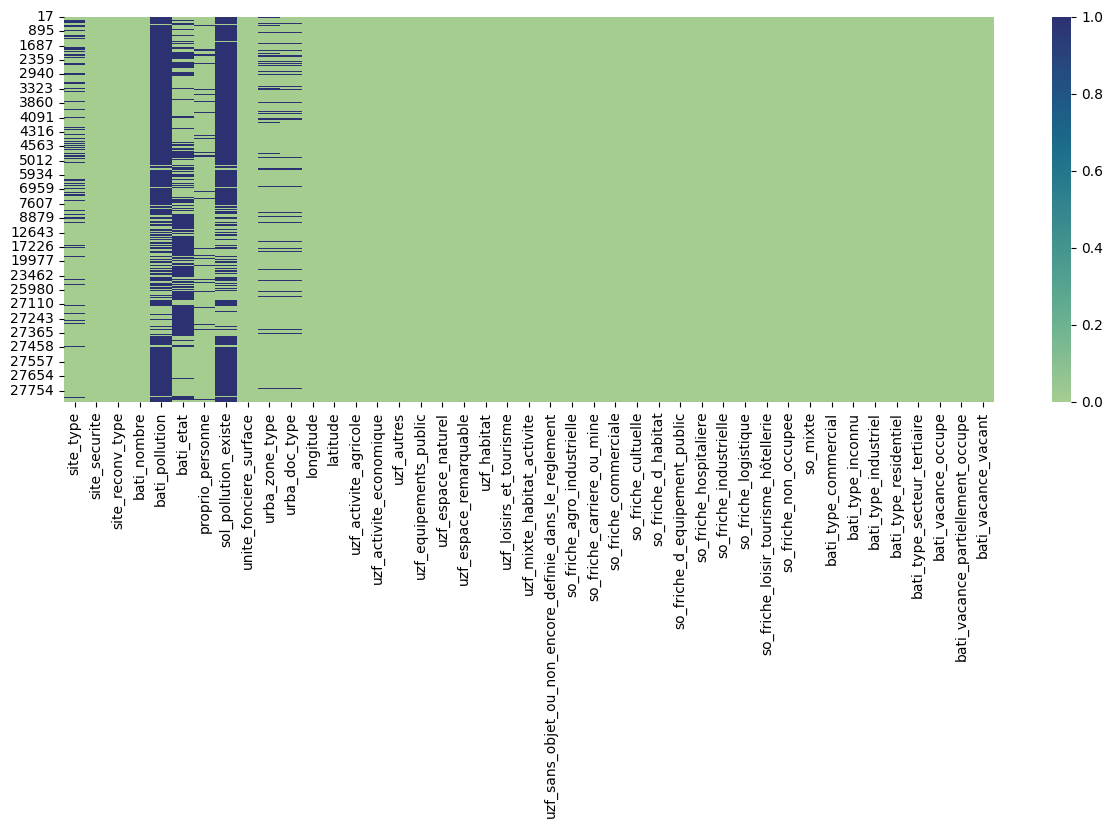

In [59]:
display(audit(df_friches_reconv))

df_friches_reconv.to_csv('./data/friches_silver.csv', index=False)

check_nan(df_friches_reconv)
